In [38]:
import os
import numpy as np
import nibabel as nib
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import helper_functions.visualizations as vis
import importlib
import helper_functions.reshape_data as rd
import helper_functions.filter_CT as fct
import cv2
import time
import scipy.ndimage as ndimage

In [2]:
root_data_dir = '/Users/akre96/Documents/GradSchool/Class/BE223A/BE223A_2019/data' # Change for different systems
subject = 'subject_2'

# 'b' images seem to have fewer things around them, no pins in either
fluoro_jpeg_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'fluoro_' + subject + '.jpg'
    )
)
hull_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull_' + subject + '.nii'
    )
)

preop_CT_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'preopCT_' + subject + '.nii'
    )
)

In [39]:
preop_CT = nib.load(preop_CT_path)
preop_CT_data = preop_CT.get_fdata()
long_data = rd.voxels_to_4D(preop_CT_data)
preop_CT_data.shape


(256, 256, 176) (256, 256, 176)


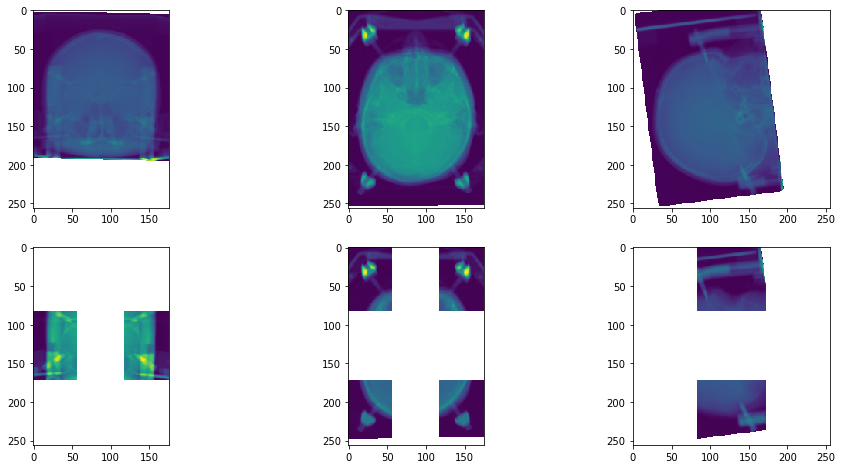

In [48]:
# Remove middle sections and edges to clean image
importlib.reload(fct)
filtered = fct.remove_ct_blocks(preop_CT_data, 35, 35, 35)
axes = vis.compare_filtered_original(preop_CT_data, filtered)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1325c1748>,
      dtype=object)

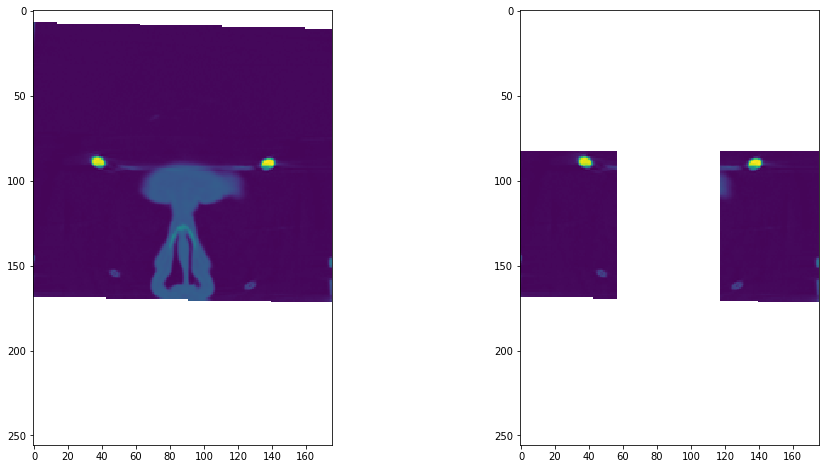

In [49]:
importlib.reload(vis)
vis.compare_slices([preop_CT_data, filtered], ['i'] * 2, [50] * 2)

# Using Scikit-image to find circles for the pin tips in 2D
- Goes through coronal plane slices to isolate circles

In [6]:
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.morphology import disk
from skimage.filters.rank import maximum
from skimage.draw import circle_perimeter


Normalizing from: -1584.5986328125 3540.65380859375
To range: 0.0 1.0


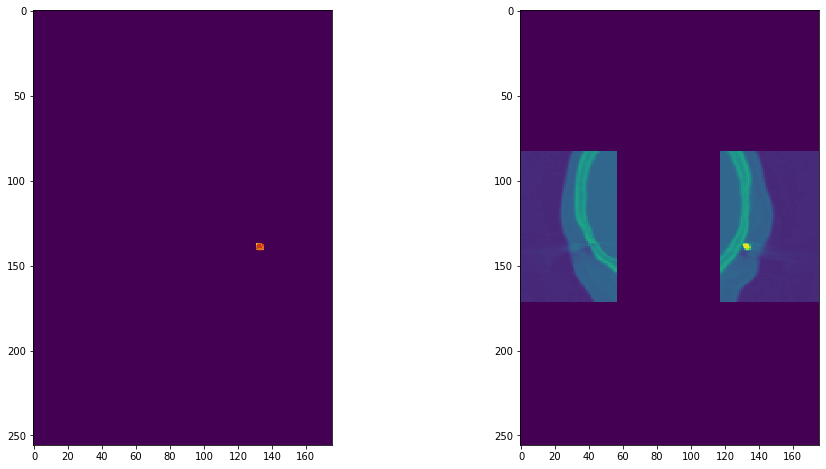

In [50]:
importlib.reload(fct)
min_max_filt = fct.min_max_normalize(filtered)
image_raw = np.nan_to_num(rd.get_slice(min_max_filt, 'i', 200))
max_filt_img = image_raw.copy()
max_filt_img[max_filt_img < .6] = 0

canny_filt = canny(max_filt_img, sigma=1)
# Detect two radii
hough_radii = np.arange(2, 10, 10)
hough_res = hough_circle(canny_filt, hough_radii)
# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=2)

# Draw them
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image_raw.shape)
    axes[0].plot(circx, circy, '-r', alpha=0.5)
axes[0].imshow(max_filt_img)
axes[0].imshow(canny_filt, alpha=.5)
axes[1].imshow(image_raw);

In [52]:
importlib.reload(fct)
pin_tip_ct = fct.isolate_pin_tips(
    filtered,
    threshold=0.6,
    hough_radii=np.arange(2, 10, 10)
)
pin_tip_ct.shape

Normalizing from: -1584.5986328125 3540.65380859375
To range: 0.0 1.0


(256, 256, 176)

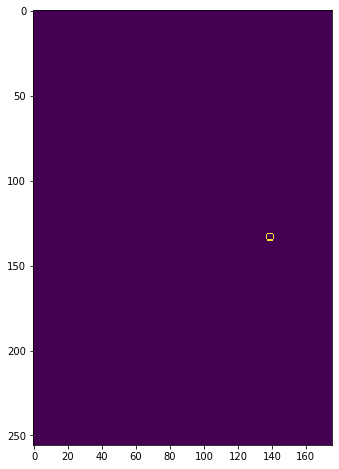

In [53]:
vis.plot_slice(pin_tip_ct, 'i', 200)

Normalizing from: 0.014122565276920795 3469.28955078125
To range: 0.0 1.0


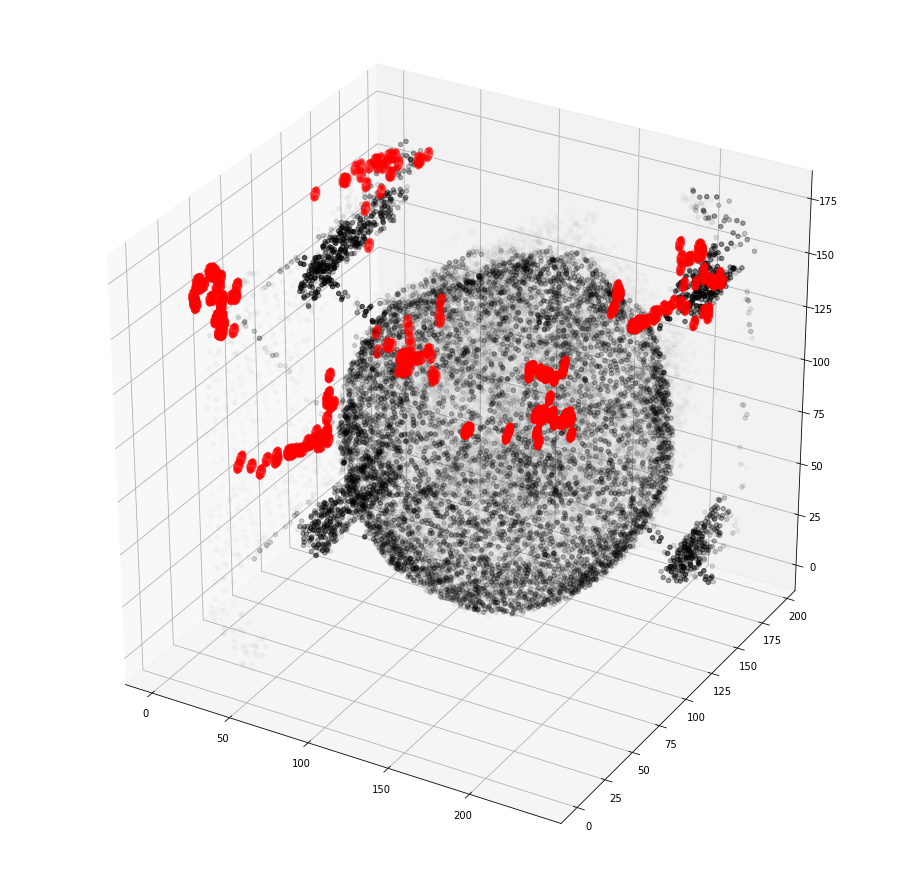

In [54]:
importlib.reload(vis)
ax = vis.quick_plot_3D(
    long_data,
    step_size=50,
    is_long=True
)
vis.quick_plot_3D(
    pin_tip_ct,
    step_size=1,
    base_color=(1,0,0),
    is_norm=True,
    ax=ax
);
